# Quick start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Poirazi-Lab/DendroTweaks/blob/main/docs/source/tutorials/Quickstart.ipynb)

This quick start tutorial will guide you through the basic steps of creating single-cell biophysical neuronal models in DendroTweaks.

We will use the standalone DendroTweaks Python package to build a detailed biophysical model of a L2/3 pyramidal neuron from the mouse visual cortex (Park et al., 2019). We will start by loading and examining morphological reconstruction from an SWC file. Next, we will add membrane mechanisms, such as ion channels, from MOD files and insert them into cell domains (e.g., apical, basal). We will then learn how to adjust different model parameters and run simulations. Finally, we will use built-in validation protocols to examine the responses of our model in order to be able to compare them to experimental data.

Alternatively, you can run `Park_2019` model using the GUI provided on our online platform at [https://dendrotweaks.dendrites.gr](https://dendrotweaks.dendrites.gr/).

## Setup

In [ ]:
!pip install dendrotweaks --quiet

If you are using Google Colab, you might also need to restart the session as the installation downgraded some packages (numpy). You can do it manually or programmatically as shown below:

In [2]:
# import os
# os.kill(os.getpid(), 9)

Let's begin by importing the standard libraries and the dendrotweaks library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import dendrotweaks as dd
dd.__version__

'0.5.1'

In [3]:
dd.apply_dark_theme() # Set the theme for the plots

## Organizing model data

Before diving into model building, we need to establish a well-organized directory structure for our model data. First, we create the `examples` directory that will store all of our models and download the example models and their corresponding data from the Github repository.

In [4]:
os.makedirs('examples', exist_ok=True)
if not os.listdir('examples/'):
    print("Downloading example data...")
    dd.download_example_data('examples')

Extracting relevant folders to examples...
Data downloaded and extracted successfully to examples/.


In [5]:
os.listdir('examples/')

['Park_2019',
 'test_model_compatibility.ipynb',
 'Templates',
 'Hay_2011',
 'Toy',
 'Smith_2013',
 'Default',
 'Poirazi_2003']

The generic model directory structure is shown below:

<div style="display: flex; align-items: left; flex-direction: column;">
<img src="../_static/model_structure.png" style="width: 80%;">
</div>

At the beginning, each model requires two essential components: neuronal morphology (stored as SWC files in the `morphology` folder) and membrane mechanisms (ion channels defined as MOD files in the `biophys/mod` folder).


<div style="
  border-left: 6px solid #27ae60;
  background-color: #19241c;
  color: lightgray;
  padding: 12px 16px;
  margin: 16px 0;
  border-radius: 4px;
  width: 95%;
  font-family: 'Segoe UI', sans-serif;
">
  <div style="font-weight: bold; color: #2ecc71; margin-bottom: 4px;">Tip</div>
  Don’t worry about compiling the MOD files manually - DendroTweaks will handle this step automatically later in the process.
</div>


## Creating a model

With our directory structure in place, we can now create a `model` object. In order to do so, we must specify the path to the folder containing the model files.

In [6]:
path_to_model = os.path.join('examples', 'Park_2019')
print(f'Path to model: {path_to_model}')

Path to model: examples/Park_2019


This `model` object serves as the central interface for managing all model components, including morphology, kinetics and distribution of membrane mechanisms, and stimuli.

In [7]:
model = dd.Model(path_to_model)

When we instantiate the model by specifying the path to our model directory, DendroTweaks automatically sets up additional required folders. It creates a `Default` folder containing standard mechanisms and a `Templates` folder with JINJA templates (e.g. for converting MOD files to Python classes). These folders are created only once and are shared across all models. 

Within your model folder, it generates a `stimuli` directory for stimulation protocols and a `biophys/python` folder for storing Python files generated from MOD files.

This structure provides the foundation for model development. As we progress, we will add more files to these directories, but the basic framework is now ready. You can learn more about the directory structure in the [tutorial](https://dendrotweaks.readthedocs.io/en/latest/tutorials/tutorial_io.html) on loading and saving models.

## Morphology

We will proceed by loading the morphology of the cell from an SWC file. First, we list the available morphologies in the morphology subfolder.

In [8]:
model.list_morphologies()

['original', 'main', 'main_block_na', 'main_reduced_apic']

We can load a specific morphology using the `load_morphology` method.

In [9]:
model.load_morphology(file_name='original')

Sorted PointTree(root=Point(idx=0), num_nodes=2214).
Extended 44 nodes.
Sorted PointTree(root=Point(idx=0), num_nodes=2258).


In DendroTweaks, we represent neuronal morphologies as hierarchical tree graphs. A single neuron can be represented in three distinct ways: the point tree, the section tree, and the segment tree. Each tree graph contains nodes that correspond to different elements: points from a morphology reconstruction (SWC file), sections, or spatial segments. The edges between nodes show parent-child relationships. These three representations capture different levels of abstraction: geometry (point tree), topology (section tree), and spatial discretization (segment tree).

<div style="display: flex; align-items: center; flex-direction: column;">
<img src="../_static/trees.png" style="width: 60%;">
</div>

These tree-based representations work together to provide complementary views of the cell's structural organization and spatial relationships. They are interconnected, with each section linking to both its geometry (points) and its segmentation (segments), and vice versa.

For more information about representing neuronal morphology with tree graphs, see the corresponding [tutorial](https://dendrotweaks.readthedocs.io/en/latest/tutorials/tutorial_morpho.html).

In [10]:
model.point_tree, model.sec_tree, model.seg_tree

(PointTree(root=Point(idx=0), num_nodes=2258),
 SectionTree(root=NeuronSection(idx=0), num_nodes=52),
 SegmentTree(root=NeuronSegment(idx=0), num_nodes=124))

We can visualize the section tree using the `plot` method:

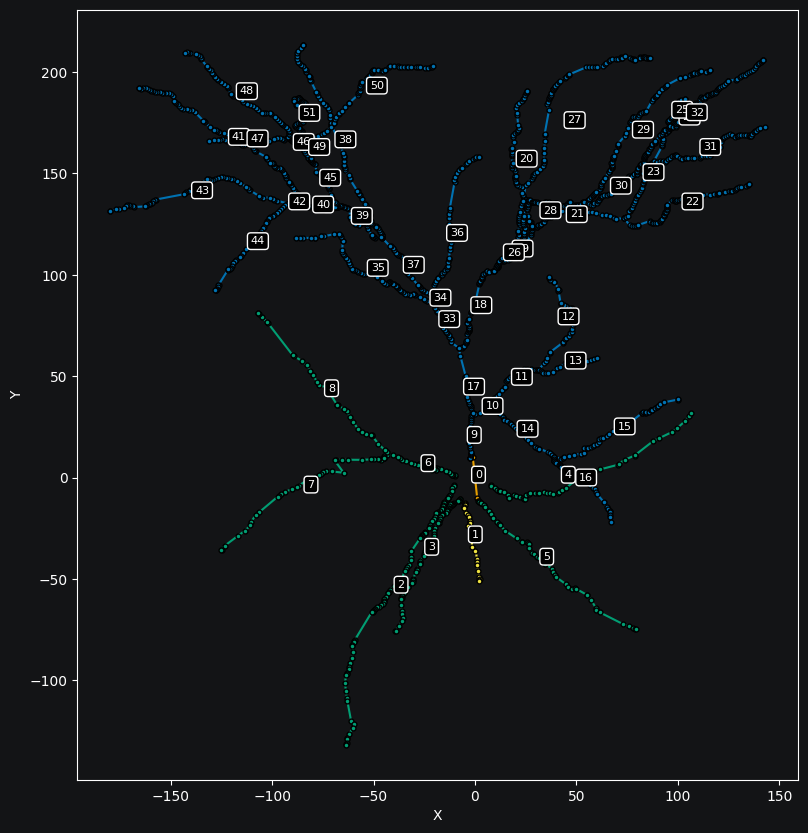

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
model.sec_tree.plot(ax, 
                    show_points=True,
                    show_lines=True,
                    annotate=True)

DendroTweaks provides a high-level model representation and integrates with external simulators to execute simulations.
By default, it uses the NEURON simulator. During the morphology loading process,
DendroTweaks automatically creates a corresponding representation of the cell in NEURON.
This allows seamless access to individual NEURON sections through their corresponding
DendroTweaks sections. For example:

In [12]:
model.sec_tree[0]._ref

__nrnsec_0x17f68700

We can calculate some important morphometric statistics for distinct anatomical and functional domains of the cell with the following function from the analysis subpackage:

In [13]:
from dendrotweaks.analysis import calculate_domain_statistics

In [14]:
calculate_domain_statistics(model, domain_names=['apic', 'soma'])

{'apic': {'N_sections': 43,
  'N_bifurcations': 21,
  'N_terminations': 22,
  'depth': {'min': 1,
   'max': 8,
   'counts': {1: 1, 2: 2, 3: 4, 4: 8, 5: 8, 6: 6, 7: 8, 8: 6}},
  'diam': {'min': 0.38, 'max': 2.06, 'mean': 0.82, 'std': 0.45},
  'length': {'min': 4.51, 'max': 154.69, 'mean': 58.31, 'std': 35.75},
  'area': {'min': 17.6, 'max': 271.28, 'mean': 130.52, 'std': 74.2},
  'total_length': 2507.17,
  'total_area': 5612.19},
 'soma': {'N_sections': 1,
  'N_bifurcations': 0,
  'N_terminations': 0,
  'depth': {'min': 0, 'max': 0, 'counts': {0: 1}},
  'diam': {'min': 20.44, 'max': 20.44, 'mean': 20.44, 'std': nan},
  'length': {'min': 20.44, 'max': 20.44, 'mean': 20.44, 'std': nan},
  'area': {'min': 1312.27, 'max': 1312.27, 'mean': 1312.27, 'std': nan},
  'total_length': 20.44,
  'total_area': 1312.27}}

### Segmentation

Computer simulations always involve approximating a continuous system as one that is discrete in space and time. Thus, we need to set the spatial discretization of the model. The spatial discretization determines the number of segments in a section. 

The optimal number of segments can be calculated based on the frequency-dependent length constant and the spatial discretization coefficient (`d_lambda`). 
To learn the underlying equations see the corresponding [tutorial](https://dendrotweaks.readthedocs.io/en/latest/tutorials/tutorial_segmentation.html). Spatial discretization also depends on the membrane capacitance and axial resistance of the model. The `seg_tree` we created before was created using default NEURON's values for capacitance and membrane resistance. In our model, we want to change those values to be more biologically relevant for our neuron.

In [15]:
model.set_param('cm', value=2)
model.set_param('cm', group_name='somatic', value=1)
model.set_param('Ra', value=100)

In [16]:
model.params

{'cm': {'all': constant({'value': 2}), 'somatic': constant({'value': 1})},
 'Ra': {'all': constant({'value': 100})}}

We should interpret the output as follows: the specific membrane capacitance `cm` is set to a constant value of 2 $\mu F/cm^2$ for all segments of the cell apart from the soma, where it is set to 1 $\mu F/cm^2$.
The axial resistance `Ra` is set to 100 $Ohm \cdot cm$
 for all segments of the cell.

We will explore how to set the model parameters in more detail later in the tutorial. For now, we have done just enough to update the spatial discretization.

In [17]:
print(f'Number of segments using the default parameters: {len(model.seg_tree)}')
model.set_segmentation(d_lambda=0.1)
print(f'Number of segments using the new parameters: {len(model.seg_tree)}')

Number of segments using the default parameters: 124
Number of segments using the new parameters: 246


We can visualize a section of the section tree using the plot method. This displays the section's geometry, with bars in the bottom-right plot corresponding to the segments.

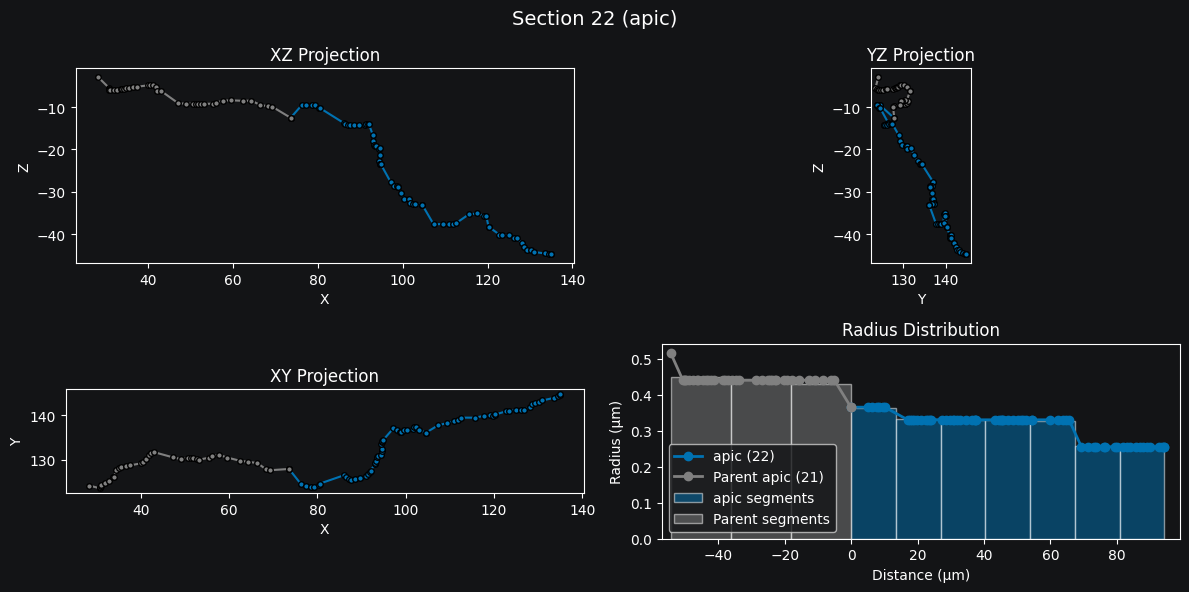

In [18]:
sec = model.sec_tree[22]
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
sec.plot(ax=ax, plot_parent=True)
plt.tight_layout()

## Membrane mechanisms

After defining the neuronal morphology, we now need to specify biophysical properties. The biophysical properties of our model depend on the mechanisms present in the membrane. These mechanisms are defined in MOD files as sets of equations and parameters, which are compiled and loaded into NEURON.

### Adding mechanisms

First, let’s add the default mechanisms to the model, which include the leak channel, calcium dynamics and synaptic mechanisms:

In [19]:
model.add_default_mechanisms(recompile=True)

However, for most of the models, we need to add user-defined mechanisms. We can create a mechanism object from a MOD file using the `add_mechanism` method. We can list the available mechanisms in the `biophys/mod` directory:

In [20]:
model.list_mechanisms()

['Na', 'KCa', 'Kv', 'Ka', 'CaHVA', 'Km', 'CaLVA']

Let's add these user-defined mechanisms to the model:

In [21]:
for mech_name in ['CaHVA', 'CaLVA', 'KCa', 'Ka', 'Km', 'Kv', 'Na']:
    model.add_mechanism(mech_name, recompile=True)

Saved content to examples/Park_2019/biophys/python/CaHVA.py
Saved content to examples/Park_2019/biophys/python/CaLVA.py
Saved content to examples/Park_2019/biophys/python/KCa.py
Saved content to examples/Park_2019/biophys/python/Ka.py
Saved content to examples/Park_2019/biophys/python/Km.py
Saved content to examples/Park_2019/biophys/python/Kv.py
Saved content to examples/Park_2019/biophys/python/Na.py


With these commands, we create Python objects from MOD files, that we will use to visualize chanel kinetics. We also compile and load the MOD files, making them available in NEURON.

To see all mechanisms available in the model, we can use the mechanisms attribute.

In [22]:
model.mechanisms

{'Leak': <Mechanism(Leak)>,
 'CaDyn': <Mechanism(CaDyn)>,
 'CaHVA': <Mechanism(CaHVA)>,
 'CaLVA': <Mechanism(CaLVA)>,
 'KCa': <Mechanism(KCa)>,
 'Ka': <Mechanism(Ka)>,
 'Km': <Mechanism(Km)>,
 'Kv': <Mechanism(Kv)>,
 'Na': <Mechanism(Na)>}

Each mechanism object is an instance of the `Mechanism` class, which contains information about the mechanism, such as its name and parameters. To examine the parameters of a specific mechanism, we can use the `params` attribute:

In [23]:
model.mechanisms['Kv'].params

{'gbar': 0.0,
 'Ra': 0.02,
 'Rb': 0.006,
 'v12': 25,
 'q': 9,
 'temp': 23,
 'q10': 2.3}

<div style="
  border-left: 6px solid #f39c12;
  background-color: #2a2514;
  color: lightgray;
  padding: 12px 16px;
  margin: 16px 0;
  border-radius: 4px;
  width: 95%;
  font-family: 'Segoe UI', sans-serif;
">
  <div style="font-weight: bold; color: #f1c40f; margin-bottom: 4px;">Warning</div>
  Note that the parameters stored within the mechanisms are the default values extracted from the MOD files. The actual values of the parameters used for the simulation are stored in the model object!
</div>


We can view the global parameters of the model using the `params` attribute:

In [24]:
model.params

{'cm': {'all': constant({'value': 2}), 'somatic': constant({'value': 1})},
 'Ra': {'all': constant({'value': 100})}}

<div style="
  border-left: 6px solid #f39c12;
  background-color: #2a2514;
  color: lightgray;
  padding: 12px 16px;
  margin: 16px 0;
  border-radius: 4px;
  width: 95%;
  font-family: 'Segoe UI', sans-serif;
">
  <div style="font-weight: bold; color: #f1c40f; margin-bottom: 4px;">Warning</div>Note that so far we have only loaded the mechanisms without actually inserting them into the membrane. Therefore, the parameters of these mechanisms are not yet included in the <code>model.params</code> dictionary. In the next step, we will insert the mechanisms into the membrane.
  </div>

### Inserting mechanisms to specific domains

In DendroTweaks, membrane mechanisms are mapped to morphological domains. A domain is a region of a neuron distinguished by its anatomical or functional properties. In a typical pyramidal cell model we have the following domains: soma, axon, basal dendrites, apical dendrite (further subdivided into trunk, tuft, and oblique dendrites).

<div style="display: flex; align-items: center; flex-direction: column;">
<img src="../_static/domains2.png" style="width: 80%;">
</div>

In DendroTweaks, a domain represents a collection of sections that share the same properties. We can view the domains of the model with the `domains` attribute.

In [25]:
model.domains

{'apic': <Domain(apic, 4, #0072B2, 43 sections)>,
 'axon': <Domain(axon, 2, #F0E442, 1 sections)>,
 'dend': <Domain(dend, 3, #019E73, 7 sections)>,
 'soma': <Domain(soma, 1, #E69F00, 1 sections)>}

Following the mechanism upload in the previous step, we need to insert the mechanisms into specific domains. For this example, we insert all available mechanisms into every domain except the axon, which receives only the leak channel.

In [26]:
for domain_name in model.domains:
    if domain_name == 'axon':
        model.insert_mechanism('Leak', 'axon', distribute=False)
        continue
    for mech_name in model.mechanisms:
        model.insert_mechanism(mech_name, domain_name, distribute=False)

We can verify which mechanisms are inserted in each domain with the `domains_to_mechs` attribute.

In [27]:
model.domains_to_mechs

{'apic': {'CaDyn', 'CaHVA', 'CaLVA', 'KCa', 'Ka', 'Km', 'Kv', 'Leak', 'Na'},
 'axon': {'Leak'},
 'dend': {'CaDyn', 'CaHVA', 'CaLVA', 'KCa', 'Ka', 'Km', 'Kv', 'Leak', 'Na'},
 'soma': {'CaDyn', 'CaHVA', 'CaLVA', 'KCa', 'Ka', 'Km', 'Kv', 'Leak', 'Na'}}

To examine the parameters of the inserted mechanisms, we can use the `mechs_to_params` attribute.

In [28]:
model.mechs_to_params

{'Independent': ['cm', 'Ra', 'eca', 'ek', 'ena'],
 'Leak': ['gbar_Leak', 'e_Leak'],
 'CaDyn': ['depth_CaDyn',
  'taur_CaDyn',
  'cainf_CaDyn',
  'gamma_CaDyn',
  'kt_CaDyn',
  'kd_CaDyn'],
 'CaHVA': ['gbar_CaHVA'],
 'CaLVA': ['gbar_CaLVA'],
 'KCa': ['gbar_KCa'],
 'Ka': ['gbar_Ka'],
 'Km': ['gbar_Km', 'v12_Km', 'q_Km'],
 'Kv': ['gbar_Kv', 'v12_Kv', 'q_Kv'],
 'Na': ['gbar_Na',
  'Rma_Na',
  'Rmb_Na',
  'v12m_Na',
  'qm_Na',
  'Rhb_Na',
  'Rha_Na',
  'v12ha_Na',
  'v12hb_Na',
  'qh_Na',
  'v12hinf_Na',
  'qhinf_Na']}

Some parameters, such as specific membrane capacitance `cm` and axial resistance `Ra`, do not belong to any mechanism. These independent parameters are grouped under an “Independent” pseudo-mechanism for interface consistency. These parameters are available in each domain by default.

At this point, we have inserted the mechanisms into the membrane and set the default parameters for the model. We can inspect the parameters of the model using the `params` attribute.

In [29]:
model.df_params

,Mechanism,Parameter,Group,Distribution,Distribution params
0,Independent,cm,all,constant,{'value': 2}
1,Independent,cm,somatic,constant,{'value': 1}
2,Independent,Ra,all,constant,{'value': 100}
3,Independent,eca,all,constant,{'value': 140}
4,Independent,ek,all,constant,{'value': -77}
5,Independent,ena,all,constant,{'value': 50}
6,Leak,gbar_Leak,all,constant,{'value': 0.0}
7,Leak,e_Leak,all,constant,{'value': -70}
8,CaDyn,depth_CaDyn,all,constant,{'value': 0.1}
9,CaDyn,taur_CaDyn,all,constant,{'value': 80}


As we can see, all parameters are set to their default values (from the MOD files) across all segments of the cell, with some parameters initialized to 0.0. Before running the simulation, we need to set these parameters to more realistic values, which we will learn how to do in the next step.

## Model parameters

In real neurons, properties such as ion channel density vary across different regions of the cell. To distribute parameters across the cell, we need to specify **where** and **how** the parameter will be distributed.

To select the segments **where** a given distribution will be applied, we use segment groups. A segment group is a collection of segments that meet certain criteria, such as the diameter or distance from the soma. 

To define **how** the parameter will be distributed, we use distribution functions. A distribution function takes a segment’s distance from the soma as input and returns the parameter value at that distance. The figure below shows an example of a segment group for the apical nexus region and a Gaussian distribution function for a parameter, such as ion channel conductance.

<div style="display: flex; align-items: center; flex-direction: column;">
<img src="../_static/distribution.png" style="width: 80%;">
</div>

### Defining segment groups

By default DendroTweaks creates a group for each domain and the `all` group for the entire cell.

In [30]:
model.groups

{'all': SegmentGroup("all", domains=['apic', 'axon', 'dend', 'soma']),
 'apical': SegmentGroup("apical", domains=['apic']),
 'axonal': SegmentGroup("axonal", domains=['axon']),
 'dendritic': SegmentGroup("dendritic", domains=['dend']),
 'somatic': SegmentGroup("somatic", domains=['soma'])}

We will need more specific groups to reproduce biologicaly realistic distribution of ion channels in the cell.
Available values for the **select_by** argument are:
- _diam_ - diameter of the segment
- _section_diam_ - diameter at the center of the section to which the segment belongs
- _distance_ - distance of the segment center from the soma center
- _domain_distance_ - distance of the segment center from the closest parent segment in a different domain

In [31]:
model.add_group(
    'dendritic_thin', domains=['dend', 'apic'],
    select_by='section_diam', max_value=0.8
)
model.add_group(
    'dendritic_thick', domains=['dend', 'apic'],
    select_by='section_diam', min_value=0.8
)

model.add_group(
    'proximal_apical', domains=['apic'],
    select_by='distance', max_value=260
)
model.add_group(
    'distal_apical', domains=['apic'],
    select_by='distance', min_value=260
)

model.add_group('basal', domains=['dend'])

model.add_group('dendritic', domains=['dend', 'apic'])

### Distributing ion channels

To define **how** the parameter will be distributed, we use distribution functions. A distribution function takes a segment’s distance from the soma as input and returns the parameter value at that distance.

We can set the values of the parameters for the mechanisms inserted in the model using the `set_param` method, specifying the group name and the distribution type.

In [32]:
# Leak
Rm = 11000
model.set_param('gbar_Leak', value=1/Rm)

# Na
model.set_param('gbar_Na', group_name='somatic', value=0.0505)
model.set_param('gbar_Na', group_name='dendritic', value=0.0303)

# # Kv
model.set_param('gbar_Kv', group_name='somatic', value=0.005)
model.set_param('gbar_Kv', group_name='dendritic', value=0.000_15)

# # Km
model.set_param('gbar_Km', group_name='somatic', value=0.0002794)
model.set_param('gbar_Km', group_name='dendritic', value=0.000127)

# Ka
model.set_param('gbar_Ka', group_name='somatic', value=0.0054)
model.set_param('gbar_Ka', group_name='dendritic_thin', value=0.108)
model.set_param('gbar_Ka', group_name='dendritic_thick', value=0.0108)

# Kca
model.set_param('gbar_KCa', group_name='somatic', value=0.000_21)
model.set_param('gbar_KCa', group_name='dendritic', value=0.000_21)

The above channels have simple constant distribution with some difference between groups. Note that we will use more complex distributions for the calcium channels:

In [33]:
#CaHVA
model.set_param('gbar_CaHVA', group_name='somatic', value=0.000_005)
model.set_param('gbar_CaHVA', group_name='basal', 
    distr_type='linear', slope=0.000_000_01, intercept=0.000_005)
model.set_param('gbar_CaHVA', group_name='proximal_apical', 
    distr_type='sinusoidal', amplitude=0.000_004923, frequency=0.008758, phase=0.8656)
model.set_param('gbar_CaHVA', group_name='distal_apical', value=0.000_002)

# CaLVA
model.set_param('gbar_CaLVA', group_name='somatic', value=0.000_03)
model.set_param('gbar_CaLVA', group_name='basal', 
    distr_type='linear', slope=0.000_000_06, intercept=0.000_03)
model.set_param('gbar_CaLVA', group_name='proximal_apical', 
    distr_type='sinusoidal', amplitude=0.000_029538, frequency=0.008758, phase=0.8656)
model.set_param('gbar_CaLVA', group_name='distal_apical', value=0.000_012)

The following distribution functions are available, along with their expected parameters:

- **constant**: Requires a _value_ parameter.
- **linear**: Requires _slope_ and _intercept_ parameters.
- **exponential**: Requires _vertical_shift_, _scale_factor_, _growth_rate_, and _horizontal_shift_ parameters.
- **sigmoid**: Requires _vertical_shift_, _scale_factor_, _growth_rate_, and _horizontal_shift_ parameters.
- **sinusoidal**: Requires _amplitude_, _frequency_, and _phase_ parameters.
- **gaussian**: Requires _amplitude_, _mean_, and _std_ parameters.

We can also set up the parameters for internal calcium dynamics:

In [34]:
# Internal calcium dynamics
model.set_param('depth_CaDyn', value=0.1)
model.set_param('taur_CaDyn', value=50)
model.set_param('cainf_CaDyn', value=1e-4)
model.set_param('gamma_CaDyn', value=1)
model.set_param('kt_CaDyn', value=0)
model.set_param('kd_CaDyn', value=0)

We can visualize the distribution of ion channel conductances in our model as a function of distance from the soma.

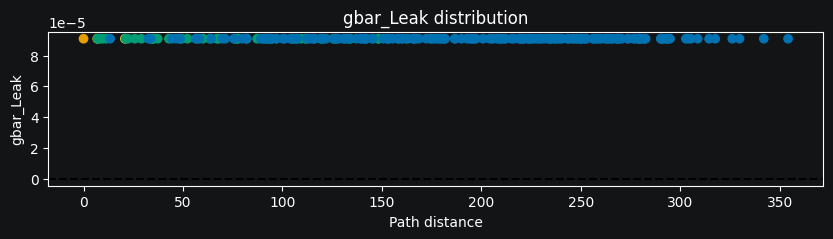

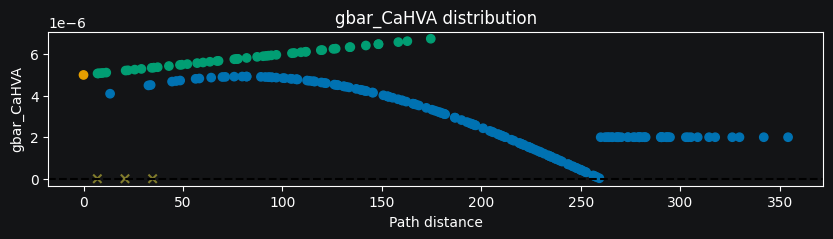

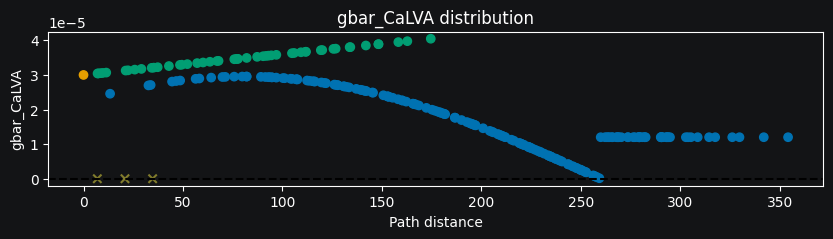

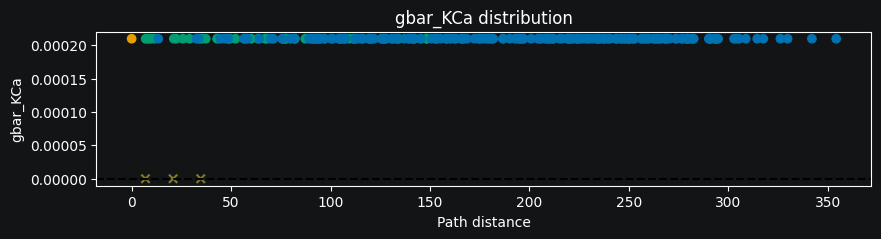

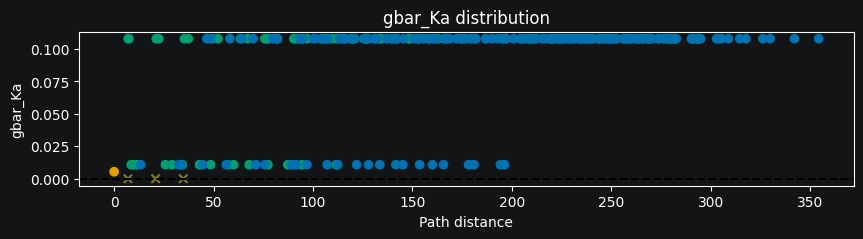

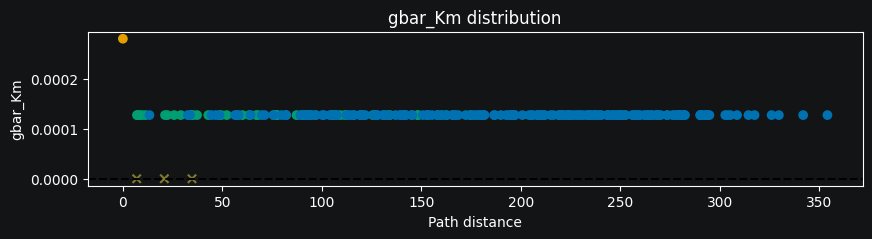

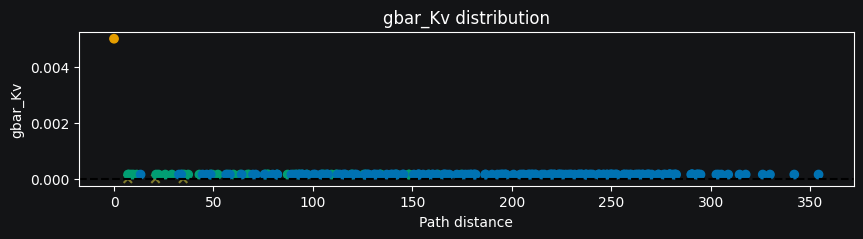

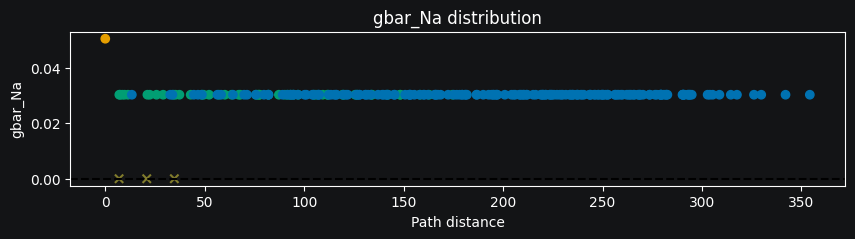

In [35]:
for param_name in model.conductances:
    fig, ax = plt.subplots(figsize=(10, 2))
    model.plot_param(param_name, ax=ax)

We can also set other parameters, such as reversal potentials, temperature, and initial membrane potential.

In [36]:
model.set_param('e_Leak', value=-79)
if 'ena' in model.params:
    model.set_param('ena', value=60)
if 'ek' in model.params:
    model.set_param('ek', value=-80)
if 'eca' in model.params:
    model.set_param('eca', value=140)
model.set_param('temperature', value=37)
model.set_param('v_init', value=-79)

In [38]:
# model.distribute_all()

Now, we can access the model parameters again and see that the values have been updated.

In [37]:
model.df_params

,Mechanism,Parameter,Group,Distribution,Distribution params
0,Independent,cm,all,constant,{'value': 2}
1,Independent,cm,somatic,constant,{'value': 1}
2,Independent,Ra,all,constant,{'value': 100}
3,Independent,eca,all,constant,{'value': 140}
4,Independent,ek,all,constant,{'value': -80}
5,Independent,ena,all,constant,{'value': 60}
6,Leak,gbar_Leak,all,constant,{'value': 9.09090909090909e-05}
7,Leak,e_Leak,all,constant,{'value': -79}
8,CaDyn,depth_CaDyn,all,constant,{'value': 0.1}
9,CaDyn,taur_CaDyn,all,constant,{'value': 50}


To learn more about segment groups and parameter distributions, refer to the [tutorial](https://dendrotweaks.readthedocs.io/en/latest/tutorials/tutorial_distributions.html) on distributing parameters.

We can export the membrane configuration and store it in a JSON file:

In [38]:
model.export_biophys(file_name='main', indent=4)

## Simulation and analysis

We will learn how to simulate neuronal activity by injecting current and adding synapses to the neuron model and recording its response. This process mimics experimental electrophysiology where researchers inject current into neurons to study their firing properties.

We will increase the numerical simulation time step from $0.025 \ ms$ to $0.01\ ms$, which will speed up the simulations while only slightly reducing precision.

In [39]:
model.simulator.dt = 0.1

### Somatic spikes

Let's begin by examining somatic action potentials. For this we will inject depolarizing current step at the soma and record the somatic voltage. 

Let's first create a new variable for easy access to the soma

In [40]:
soma = model.sec_tree[0] # or alternatively: model.domains['soma'].sections[0]
soma

NeuronSection(idx=0)

We will add a recording point at the center of the soma. The `loc` parameter specifies the location along the section where the recording will be placed. It is a normalized length, with 0.0 representing the start of the section and 1.0 representing the end.

In [41]:
model.add_recording(soma, loc=0.5)

Now we will apply a current step stimulus to drive the neuron to fire action potentials. This mimics the experimental technique where constant current is injected into a neuron.

We specify the duration of the stimulus in ms, the delay before the stimulus starts, and the amplitude of the stimulus in nanoamperes.

In [42]:
model.add_iclamp(soma, loc=0.5, amp=0.162, delay=50, dur=900)

With our recording and stimulus in place, we can now run a simulation. 

In [43]:
model.simulator.run(1000);

This runs the simulation for 1000 milliseconds (1 second). After the simulation completes, the voltage data is stored in `simulator.recordings['v']` and the corresponding time points in `simulator.t`.

We will use built-in DendroTweaks functions to plot the voltage trace and extract spike metrics.

In [44]:
from dendrotweaks.analysis import detect_somatic_spikes, plot_somatic_spikes

Detected 7 spikes
Average spike half-width: 1.05 ms
Average spike amplitude: 76.69 mV
Spike frequency: 7.78 Hz


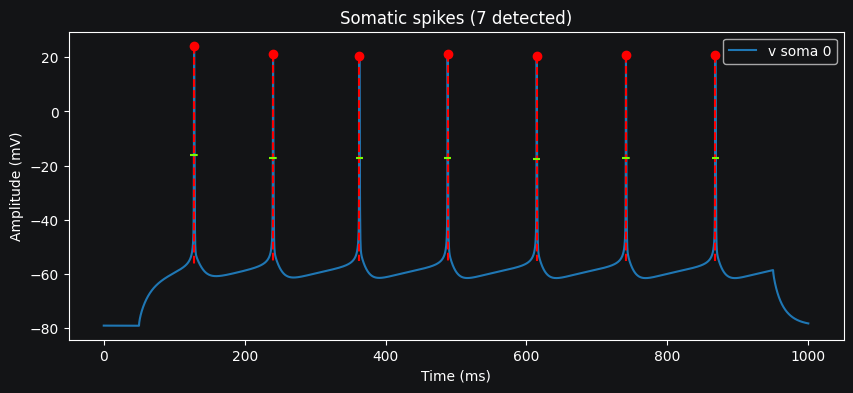

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
model.simulator.plot_voltage(ax=ax)
spike_data = detect_somatic_spikes(model)
plot_somatic_spikes(spike_data, ax, show_metrics=True)

We can export this specific simulation protocol with all the recordings and stimuli in place:

In [46]:
model.export_stimuli(file_name='current_soma_depol')

In [47]:
model.list_stimuli()

['current_soma_depol',
 'current_soma_depol_block_na',
 'current_dend_hyperpol_attenuation',
 'syn_apic_50_ampa',
 'current_soma_hyperpol']

### Synapses

Now let's place some AMPA synapses on the apical tree of our neuron. For this we will create a `Population` object that represents a population of "virtual" neurons that project to our neuron. To create a population we need to specify the type (AMPA) and the number (50) of synapses to be formed and the segments of the model where they will be randomly distributed. We can then update the input parameters such as rate of incoming inputs and kinetic parameters such as rise and decay time constants.

In [48]:
model.remove_all_stimuli()
model.remove_all_recordings()

model.add_recording(soma, loc=0.5)

segments = model.get_segments(['apical'])
model.add_population(
    name='excitatory',
    segments=segments, 
    N=50, 
    syn_type='AMPA'
)
model.update_population_input_params('excitatory', rate=30, end=800, noise=1, seed=42)
model.update_population_kinetic_params('excitatory', tau_rise=0.1, tau_decay=2.5)

{'rate': 30, 'noise': 1, 'start': 100, 'end': 800, 'weight': 1, 'delay': 0, 'seed': 42}
{'gmax': 0.001, 'tau_rise': 0.1, 'tau_decay': 2.5, 'e': 0}


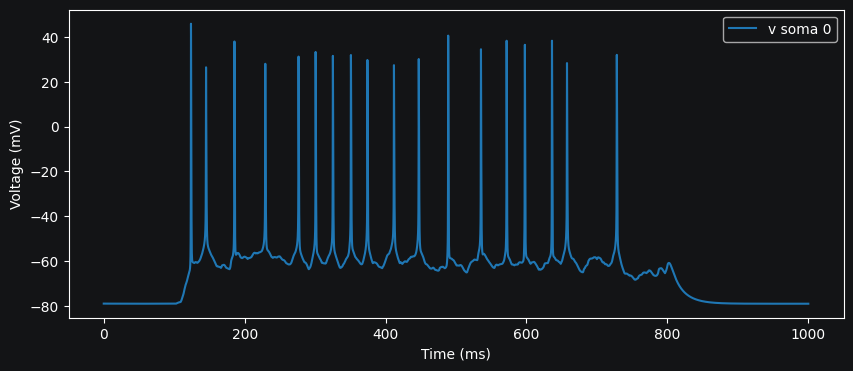

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
model.simulator.run(1000)
model.simulator.plot_voltage(ax=ax)

We can visualize the spike times of the pre-synaptic "virtual" neurons with the following code:

Text(0.5, 1.0, 'AMPA Synaptic Activity')

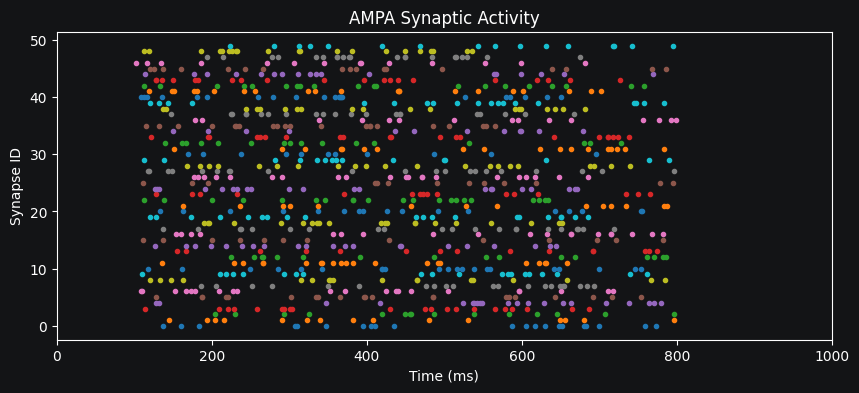

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
spike_times = model.populations['excitatory'].spike_times
for i, (syn, times) in enumerate(spike_times.items()):
    ax.plot(times, np.ones_like(times) * i, '.')

ax.set_xlim(0, 1000)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Synapse ID')
ax.set_title('AMPA Synaptic Activity')

To learn more about synapses, refer to the corresponding [tutorial](https://dendrotweaks.readthedocs.io/en/latest/tutorials/tutorial_synapses.html).

In [51]:
model.export_stimuli(file_name='syn_apic_50_ampa')

### Voltage attenuation in dendrites

Next, we will explore passive and active properties of dendrites. We will start by evaluating how a stimulus amplitude attenuates as the signal propagates from a dendrite to the soma. For this, we will record the activity from several locations along a path from the tip of a dendrite to the soma.

In [52]:
from dendrotweaks.analysis import calculate_voltage_attenuation, plot_voltage_attenuation

In [53]:
model.remove_all_stimuli()
model.remove_all_recordings()

secs = [model.sec_tree[i] for i in [0, 9, 17, 18, 21, 22]]
for sec in secs:
    model.add_recording(sec, loc=0.5)

model.add_iclamp(secs[-1], loc=0.5, amp=-0.01, delay=100, dur=800)

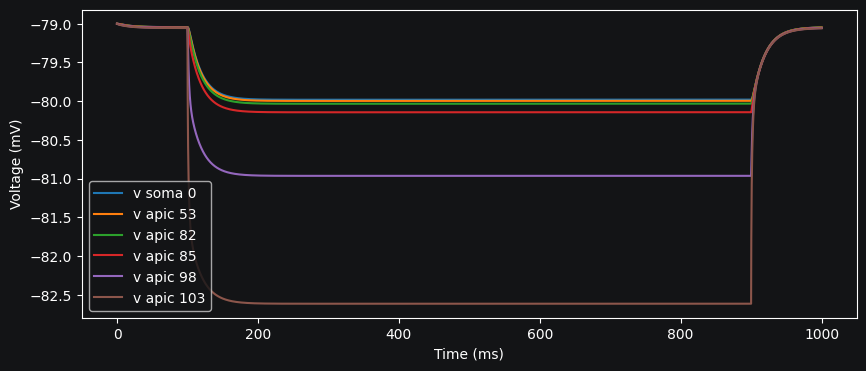

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
model.run(1000)
model.simulator.plot_voltage(ax=ax)

We will use `calculate_voltage_attenuation` to calculate how the voltage deflection from the resting membrane potential drops as we move further away from the injection site at the dendrite. Note that the rightmost point represents the injection site at the dendrite, which is the maximum distance from the soma.

Stimulating segment: NeuronSegment(idx=103)
Recording segments: [NeuronSegment(idx=0), NeuronSegment(idx=53), NeuronSegment(idx=82), NeuronSegment(idx=85), NeuronSegment(idx=98), NeuronSegment(idx=103)]


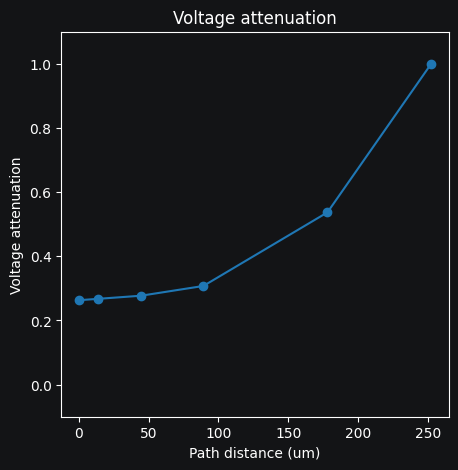

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
attenuation_data = calculate_voltage_attenuation(model)
plot_voltage_attenuation(attenuation_data, ax)

In [56]:
model.export_stimuli(file_name='current_dend_hyperpol_attenuation')

### Dendritic nonlinearities

Dendrites are not merely passive cables; they actively process synaptic inputs through mechanisms such as voltage-gated ion channels and NMDA receptor activation. When sufficiently strong or coincident inputs activate these channels, dendritic spikes can be generated. These local regenerative events create regions of nonlinear synaptic integration, where the combined effect of multiple inputs deviates from the linear sum of individual responses—resulting in either supralinear or sublinear summation. These nonlinearities can significantly impact the neuron's integrative properties and information processing.

In [57]:
from dendrotweaks.analysis import calculate_dendritic_nonlinearity, plot_dendritic_nonlinearity

To examine dendritic nonlinearities, we can gradually increase the synaptic input at a dendritic location and observe the resulting voltage responses.

To set up the experiment, we need to place a synapse on a dendritic branch and record the voltage at the same location:

In [58]:
model.remove_all_stimuli()
model.remove_all_recordings()

sec = model.sec_tree[22]
model.add_recording(sec, loc=0.5)
segments = [sec(0.5)]

model.add_recording(sec, loc=0.5)
model.add_population(
    name='scaled_synapse',
    segments=segments, 
    N=1, 
    syn_type='AMPA'
)

The `calculate_dendritic_nonlinearity` function will then gradually increase the synaptic weight (equivalent to increasing the number of synapses, given their synchronous activation) and compare the amplitude of the resulting post-synaptic potentials (PSPs) to the linearly increasing amplitude of a unitary PSP:

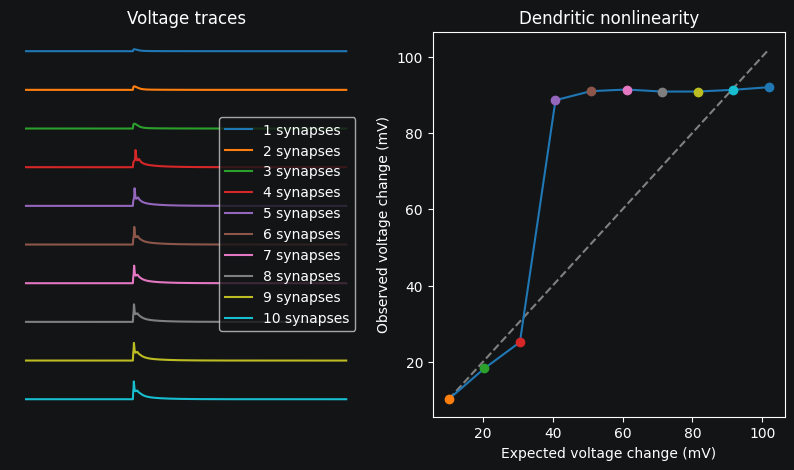

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
data = calculate_dendritic_nonlinearity(model, duration=300, max_weight=10, n=10)
plot_dendritic_nonlinearity(data, ax=ax)
ax[0].legend(loc='right')


You can learn more in the [tutorial](https://dendrotweaks.readthedocs.io/en/latest/tutorials/tutorial_validation.html) on analyzing simulation results.

---

<div style="text-align: center; color:rgb(187 86 150);">
    <strong>Congratulations! This concludes our quick start tutorial 🎉🎉🎉</strong>
</div>


We have covered the fundamental steps to create and simulate a single-cell biophysical neuronal model using DendroTweaks and you are now ready to build more complex models.